Imports loaded.
Shapes:
X        : (1011, 37)
y_multi  : (1011, 20)
y_binary : (1011, 1)

Index lengths:
train: 413, valid: 203, test: 395

Split shapes:
X_train: (413, 37) X_valid: (203, 37) X_test: (395, 37)
y_train_multi: (413, 20) y_valid_multi: (203, 20) y_test_multi: (395, 20)
y_train_bin: (413,) y_valid_bin: (203,) y_test_bin: (395,)

Class index → name mapping (multi-class):
0: basal cell carcinoma
1: blue nevus
2: clark nevus
3: combined nevus
4: congenital nevus
5: dermal nevus
6: dermatofibroma
7: lentigo
8: melanoma
9: melanoma (0.76 to 1.5 mm)
10: melanoma (in situ)
11: melanoma (less than 0.76 mm)
12: melanoma (more than 1.5 mm)
13: melanoma metastasis
14: melanosis
15: miscellaneous
16: recurrent nevus
17: reed or spitz nevus
18: seborrheic keratosis
19: vascular lesion

Training set class distribution (index → count):
0      19
1      14
2     176
3       5
4      11
5      19
6       6
7       7
9      21
10     22
11     39
12      6
13      2
14      7
15      3
16  

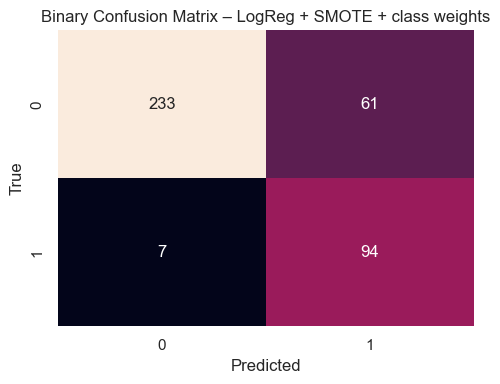

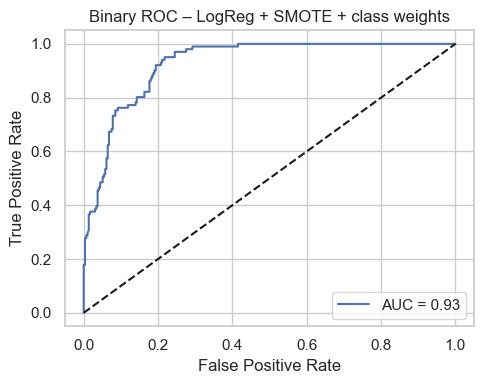


Saving binary predictions for fusion...
Binary prediction files saved:
 - val_binary_predictions.csv
 - test_binary_predictions.csv

Multi-class Baseline – Decision Tree (class-weighted)

Decision Tree – classification report:
                              precision    recall  f1-score   support

        basal cell carcinoma       0.29      0.62      0.40        16
                  blue nevus       0.22      0.18      0.20        11
                 clark nevus       0.86      0.50      0.63       156
              combined nevus       0.00      0.00      0.00         5
            congenital nevus       0.02      0.25      0.04         4
                dermal nevus       0.22      0.50      0.31         8
              dermatofibroma       0.33      0.14      0.20         7
                     lentigo       0.67      0.33      0.44        12
                    melanoma       0.00      0.00      0.00         1
   melanoma (0.76 to 1.5 mm)       0.29      0.28      0.29        18
 

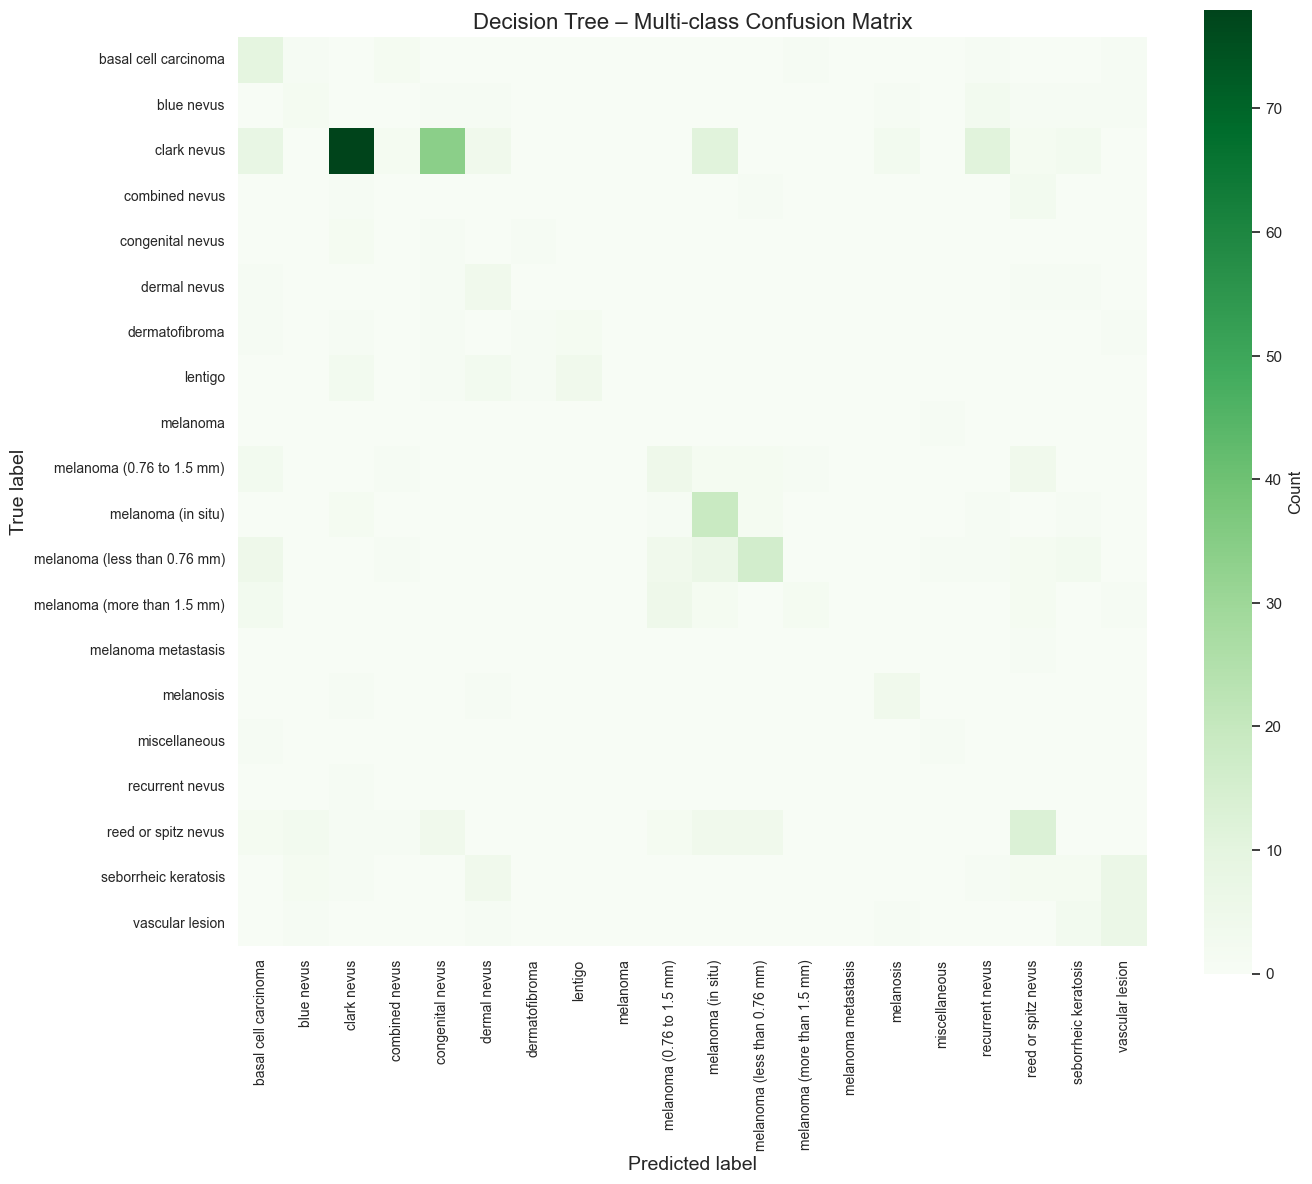


Multi-class – LightGBM (unweighted)
Training until validation scores don't improve for 30 rounds
[50]	train's multi_logloss: 0.507258	valid's multi_logloss: 1.53445
Early stopping, best iteration is:
[42]	train's multi_logloss: 0.599226	valid's multi_logloss: 1.51762

LightGBM (unweighted) – classification report:
                              precision    recall  f1-score   support

        basal cell carcinoma       0.53      0.62      0.57        16
                  blue nevus       0.56      0.45      0.50        11
                 clark nevus       0.72      0.94      0.81       156
              combined nevus       0.00      0.00      0.00         5
            congenital nevus       0.00      0.00      0.00         4
                dermal nevus       0.67      0.50      0.57         8
              dermatofibroma       1.00      0.43      0.60         7
                     lentigo       1.00      0.42      0.59        12
                    melanoma       0.00      0.00   

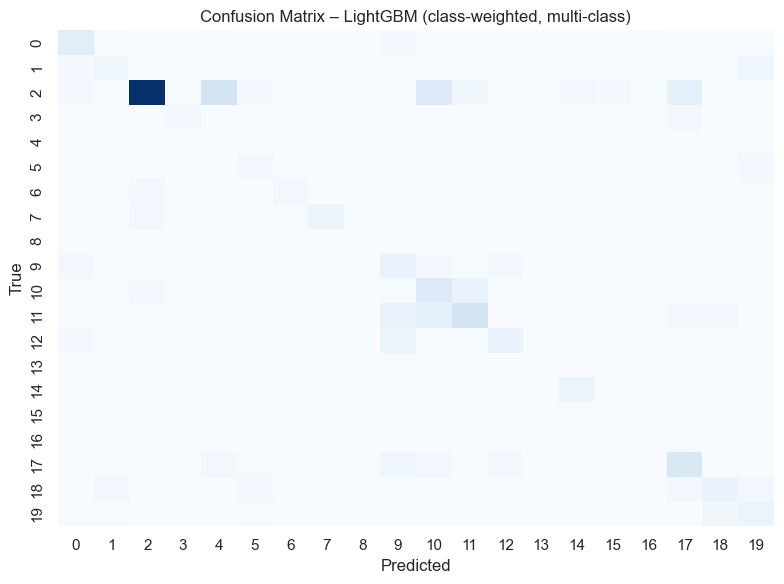


Multi-class – LightGBM (class-weighted) + isotonic calibration


C:\Users\Prianshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



LightGBM (class-weighted + calibrated) – classification report:
                              precision    recall  f1-score   support

        basal cell carcinoma       0.69      0.56      0.62        16
                  blue nevus       0.40      0.18      0.25        11
                 clark nevus       0.71      0.93      0.81       156
              combined nevus       0.00      0.00      0.00         5
            congenital nevus       0.00      0.00      0.00         4
                dermal nevus       0.50      0.50      0.50         8
              dermatofibroma       0.40      0.29      0.33         7
                     lentigo       0.43      0.25      0.32        12
                    melanoma       0.00      0.00      0.00         1
   melanoma (0.76 to 1.5 mm)       0.00      0.00      0.00        18
          melanoma (in situ)       0.16      0.31      0.21        26
melanoma (less than 0.76 mm)       0.00      0.00      0.00        40
 melanoma (more than 1.5

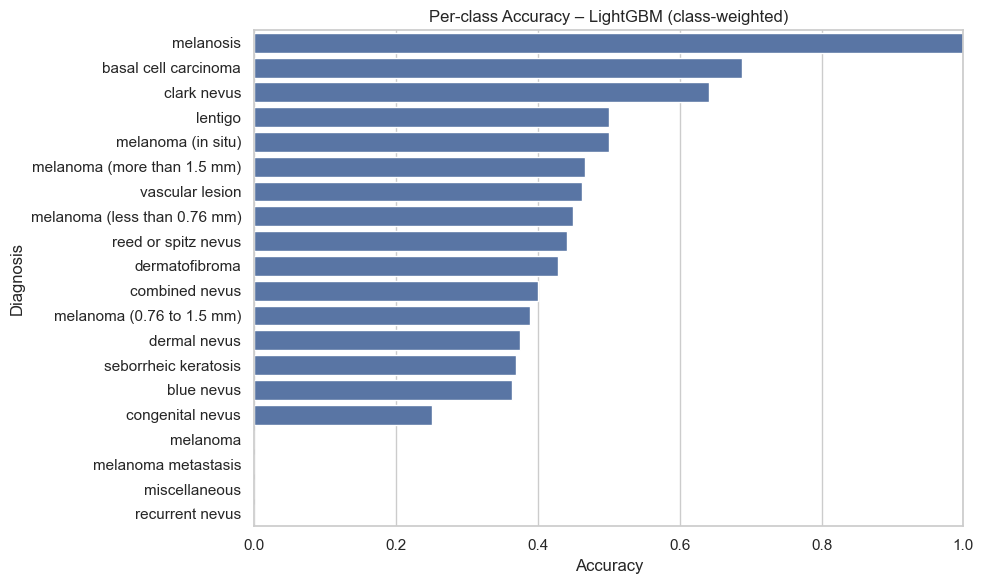


SUMMARY TABLES

Binary Baseline Summary:
                            Model  Accuracy  Precision  Recall      F1     AUC
0  LogReg + SMOTE + class weights    0.8278     0.6065  0.9307  0.7344  0.9277

Multi-class Baseline Summary:
                       Model  Accuracy  Macro F1  Macro AUC
0   Decision Tree (weighted)    0.4278    0.2828     0.6653
1      LightGBM (unweighted)    0.6127    0.3658     0.8967
2  LightGBM (class-weighted)    0.5291    0.3635     0.8989
3      LightGBM (calibrated)    0.4380    0.1518     0.7363
4     Ensemble (DT + LGBM w)    0.4658    0.3027     0.8963


In [2]:
# ======================================================
# ADVANCED TABULAR BASELINES – Derm7pt (Binary + Multi-class)
# Author: Anam Ayyub
# ======================================================
# This notebook:
#  - Loads canonical tabular features and targets
#  - Uses fixed train/valid/test splits from index files
#  - Builds:
#       * Binary baseline (LogReg + SMOTE + class weights)
#       * Multi-class baselines:
#           - Decision Tree (class-weighted)
#           - LightGBM (unweighted)
#           - LightGBM (class-weighted)
#           - LightGBM (class-weighted + isotonic calibration)
#           - Ensemble (Decision Tree + LightGBM weighted)
#  - Prints:
#       * Classification reports
#       * Summary tables (Accuracy, Macro F1, Macro AUC)
#       * Per-class accuracy table
#       * Key plots: confusion matrices, ROC (binary), per-class accuracy bar plot
#
# IMPORTANT:
#  - This code ONLY READS features.csv and targets; it does NOT overwrite any CSV.
#  - No SMOTE on multi-class (extreme rare classes → unstable). We use class weights instead.
#  - SMOTE is used ONLY for the binary baseline on the training set.
# ======================================================

# ======================================================
# Block 1 – Imports
# ======================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
import lightgbm as lgb

sns.set(style="whitegrid", context="notebook")
pd.set_option("display.max_columns", 200)

print("Imports loaded.")

# ======================================================
# Block 2 – File paths and loading data
# ======================================================
BASE_DIR = r"../Dataset/DERM7PT/meta"

FEATURES_FP       = os.path.join(BASE_DIR, "features.csv")
TARGET_MULTI_FP   = os.path.join(BASE_DIR, "target_multiclass.csv")
TARGET_BIN_FP     = os.path.join(BASE_DIR, "target_binary.csv")
TRAIN_IDX_FP      = os.path.join(BASE_DIR, "train_indexes.csv")
VALID_IDX_FP      = os.path.join(BASE_DIR, "valid_indexes.csv")
TEST_IDX_FP       = os.path.join(BASE_DIR, "test_indexes.csv")

assert os.path.exists(FEATURES_FP), "features.csv not found"
assert os.path.exists(TARGET_MULTI_FP), "target_multiclass.csv not found"
assert os.path.exists(TARGET_BIN_FP), "target_binary.csv not found"

X = pd.read_csv(FEATURES_FP)
y_multi = pd.read_csv(TARGET_MULTI_FP)
y_bin = pd.read_csv(TARGET_BIN_FP)

print("Shapes:")
print("X        :", X.shape)
print("y_multi  :", y_multi.shape)
print("y_binary :", y_bin.shape)


def read_idx(fp):
    """Safe index reader: keeps only integer-like values."""
    df = pd.read_csv(fp)
    col = df.columns[0]
    vals = df[col].tolist()
    clean = []
    for v in vals:
        try:
            clean.append(int(v))
        except Exception:
            continue
    return clean

train_idx = read_idx(TRAIN_IDX_FP)
valid_idx = read_idx(VALID_IDX_FP)
test_idx  = read_idx(TEST_IDX_FP)

print("\nIndex lengths:")
print(f"train: {len(train_idx)}, valid: {len(valid_idx)}, test: {len(test_idx)}")

# Create splits
X_train = X.iloc[train_idx].copy()
X_valid = X.iloc[valid_idx].copy()
X_test  = X.iloc[test_idx].copy()

y_train_multi = y_multi.iloc[train_idx].copy()
y_valid_multi = y_multi.iloc[valid_idx].copy()
y_test_multi  = y_multi.iloc[test_idx].copy()

# For binary, flatten to 1D arrays
y_train_bin = y_bin.iloc[train_idx].values.ravel()
y_valid_bin = y_bin.iloc[valid_idx].values.ravel()
y_test_bin  = y_bin.iloc[test_idx].values.ravel()

print("\nSplit shapes:")
print("X_train:", X_train.shape, "X_valid:", X_valid.shape, "X_test:", X_test.shape)
print("y_train_multi:", y_train_multi.shape, "y_valid_multi:", y_valid_multi.shape, "y_test_multi:", y_test_multi.shape)
print("y_train_bin:", y_train_bin.shape, "y_valid_bin:", y_valid_bin.shape, "y_test_bin:", y_test_bin.shape)

# ======================================================
# Block 3 – Class index → name mapping (multi-class)
# ======================================================
class_names = list(y_multi.columns)
print("\nClass index → name mapping (multi-class):")
for idx, name in enumerate(class_names):
    print(f"{idx}: {name}")

# Prepare label vectors for multi-class
y_train_labels = y_train_multi.values.argmax(axis=1)
y_valid_labels = y_valid_multi.values.argmax(axis=1)
y_test_labels  = y_test_multi.values.argmax(axis=1)

# Show train distribution
train_counts = pd.Series(y_train_labels).value_counts().sort_index()
print("\nTraining set class distribution (index → count):")
print(train_counts)

# ======================================================
# Block 4 – Preprocessing
#   - Tree models: original numeric + categoricals (category dtype)
#   - Logistic Regression (binary): one-hot + StandardScaler + SMOTE
# ======================================================

# 4.1 – Data for tree-based models (LightGBM + Decision Tree)
X_train_tree = X_train.copy()
X_valid_tree = X_valid.copy()
X_test_tree  = X_test.copy()

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
for col in cat_cols:
    X_train_tree[col] = X_train_tree[col].astype("category")
    X_valid_tree[col] = X_valid_tree[col].astype("category")
    X_test_tree[col]  = X_test_tree[col].astype("category")

print("\nTree-based preprocessing complete.")
print("Categorical columns:", cat_cols)

# 4.2 – Data for Logistic Regression (binary): one-hot + scaling
X_encoded = pd.get_dummies(X, drop_first=True)
X_train_lr = X_encoded.iloc[train_idx].copy()
X_valid_lr = X_encoded.iloc[valid_idx].copy()
X_test_lr  = X_encoded.iloc[test_idx].copy()

num_cols_lr = X_train_lr.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train_lr[num_cols_lr] = scaler.fit_transform(X_train_lr[num_cols_lr])
X_valid_lr[num_cols_lr] = scaler.transform(X_valid_lr[num_cols_lr])
X_test_lr[num_cols_lr]  = scaler.transform(X_test_lr[num_cols_lr])

print("\nLogistic Regression preprocessing complete.")
print("Encoded feature shape:", X_encoded.shape)

# 4.3 – SMOTE for binary training ONLY (safe k_neighbors for very small minority)
sm = SMOTE(random_state=42, k_neighbors=1)
X_train_lr_sm, y_train_bin_sm = sm.fit_resample(X_train_lr, y_train_bin)

print("\nBinary SMOTE applied on training set only.")
print("Original binary train size :", X_train_lr.shape[0])
print("Resampled binary train size:", X_train_lr_sm.shape[0])

# ======================================================
# Block 5 – Compute class weights (binary + multi-class)
# ======================================================
# Multi-class
classes_multi = np.unique(y_train_labels)
weights_multi = compute_class_weight(
    class_weight="balanced",
    classes=classes_multi,
    y=y_train_labels
)
class_weight_multi = {cls: w for cls, w in zip(classes_multi, weights_multi)}

print("\nComputed multi-class class weights (index: weight):")
for cls, w in class_weight_multi.items():
    print(f"{cls} ({class_names[cls]}): {w:.3f}")

# Binary
classes_bin = np.unique(y_train_bin)
weights_bin = compute_class_weight(
    class_weight="balanced",
    classes=classes_bin,
    y=y_train_bin
)
class_weight_bin = {int(cls): float(w) for cls, w in zip(classes_bin, weights_bin)}

print("\nComputed binary class weights (label: weight):")
for cls, w in class_weight_bin.items():
    print(f"{cls}: {w:.3f}")

# ======================================================
# Block 6 – Binary baseline: Logistic Regression + SMOTE + class weights
# ======================================================
print("\n" + "="*60)
print("Binary Baseline – Logistic Regression + SMOTE + class weights")
print("="*60)

log_reg_bin = LogisticRegression(
    max_iter=1000,
    class_weight=class_weight_bin,
    solver="liblinear",
    random_state=42
)

log_reg_bin.fit(X_train_lr_sm, y_train_bin_sm)

y_pred_bin = log_reg_bin.predict(X_test_lr)
y_proba_bin = log_reg_bin.predict_proba(X_test_lr)[:, 1]

print("\nBinary classification report (Logistic Regression):")
print(classification_report(y_test_bin, y_pred_bin, zero_division=0))

bin_acc = accuracy_score(y_test_bin, y_pred_bin)
bin_prec = precision_score(y_test_bin, y_pred_bin, zero_division=0)
bin_rec = recall_score(y_test_bin, y_pred_bin, zero_division=0)
bin_f1 = f1_score(y_test_bin, y_pred_bin, zero_division=0)
bin_auc = roc_auc_score(y_test_bin, y_proba_bin)

print("Binary metrics:")
print(f"Accuracy : {bin_acc:.4f}")
print(f"Precision: {bin_prec:.4f}")
print(f"Recall   : {bin_rec:.4f}")
print(f"F1-score : {bin_f1:.4f}")
print(f"AUC      : {bin_auc:.4f}")

# ---- Binary confusion matrix plot ----
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_bin, annot=True, fmt="d", cbar=False)
plt.title("Binary Confusion Matrix – LogReg + SMOTE + class weights")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ---- Binary ROC curve ----
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_bin)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {bin_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary ROC – LogReg + SMOTE + class weights")
plt.legend()
plt.tight_layout()
plt.show()
# ======================================================
# Block 6B – Save Binary Predictions (Validation + Test)
#   Required later for fusion / stacking
# ======================================================

print("\nSaving binary predictions for fusion...")

SAVE_DIR = BASE_DIR  # same folder where features.csv is stored

# ---- 1) Validation predictions ----
val_pred_bin  = log_reg_bin.predict(X_valid_lr)
val_proba_bin = log_reg_bin.predict_proba(X_valid_lr)[:, 1]

df_val_bin = pd.DataFrame({
    "true_label": y_valid_bin,
    "pred_label": val_pred_bin,
    "proba_1": val_proba_bin
})
df_val_bin.to_csv(os.path.join(SAVE_DIR, "val_binary_predictions.csv"), index=False)


# ---- 2) Test predictions ----
test_pred_bin  = log_reg_bin.predict(X_test_lr)
test_proba_bin = log_reg_bin.predict_proba(X_test_lr)[:, 1]

df_test_bin = pd.DataFrame({
    "true_label": y_test_bin,
    "pred_label": test_pred_bin,
    "proba_1": test_proba_bin
})
df_test_bin.to_csv(os.path.join(SAVE_DIR, "test_binary_predictions.csv"), index=False)

print("Binary prediction files saved:")
print(" - val_binary_predictions.csv")
print(" - test_binary_predictions.csv")


# ======================================================
# Block 7 – Multi-class: Decision Tree (class-weighted)
# ======================================================
print("\n" + "="*60)
print("Multi-class Baseline – Decision Tree (class-weighted)")
print("="*60)

dt = DecisionTreeClassifier(
    max_depth=8,
    random_state=42,
    class_weight="balanced"
)
dt.fit(X_train_tree, y_train_labels)

y_pred_dt = dt.predict(X_test_tree)
y_proba_dt_raw = dt.predict_proba(X_test_tree)   # shape: (n_samples, n_dt_classes)

print("\nDecision Tree – classification report:")
print(classification_report(y_test_labels, y_pred_dt, target_names=class_names, zero_division=0))

# Build full probability matrix for all classes (for AUC & ensemble)
num_classes = y_train_multi.shape[1]
proba_dt_full = np.zeros((len(y_test_labels), num_classes))
dt_classes = dt.classes_  # indices of classes seen by the tree

for i, cls in enumerate(dt_classes):
    proba_dt_full[:, cls] = y_proba_dt_raw[:, i]

dt_acc = accuracy_score(y_test_labels, y_pred_dt)
dt_f1  = f1_score(y_test_labels, y_pred_dt, average="macro")

try:
    dt_auc = roc_auc_score(y_test_multi, proba_dt_full, multi_class="ovr")
except ValueError:
    dt_auc = np.nan

print("Decision Tree metrics:")
print(f"Accuracy : {dt_acc:.4f}")
print(f"Macro F1 : {dt_f1:.4f}")
print(f"Macro AUC: {dt_auc:.4f}")
# ======================================================
# Block X — Decision Tree (class-weighted) Confusion Matrix (Green Palette)
# ======================================================

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm_dt = confusion_matrix(y_test_labels, y_pred_dt)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_dt,
    annot=False,
    cmap="Greens",          # <<< Green palette
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Count"},
    square=True
)

plt.title("Decision Tree – Multi-class Confusion Matrix", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# ======================================================
# Block 8 – Multi-class: LightGBM (unweighted)
# ======================================================
print("\n" + "="*60)
print("Multi-class – LightGBM (unweighted)")
print("="*60)

num_classes = y_train_multi.shape[1]

params_base = {
    "objective": "multiclass",
    "num_class": num_classes,
    "metric": "multi_logloss",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "verbosity": -1,
    "seed": 42
}

train_data_base = lgb.Dataset(X_train_tree, label=y_train_labels)
valid_data_base = lgb.Dataset(X_valid_tree, label=y_valid_labels)

model_lgb_base = lgb.train(
    params_base,
    train_data_base,
    valid_sets=[train_data_base, valid_data_base],
    valid_names=["train", "valid"],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=50)
    ]
)

y_proba_lgb_base = model_lgb_base.predict(X_test_tree)
y_pred_lgb_base = np.argmax(y_proba_lgb_base, axis=1)

print("\nLightGBM (unweighted) – classification report:")
print(classification_report(y_test_labels, y_pred_lgb_base, target_names=class_names, zero_division=0))

lgb_base_acc = accuracy_score(y_test_labels, y_pred_lgb_base)
lgb_base_f1  = f1_score(y_test_labels, y_pred_lgb_base, average="macro")
try:
    lgb_base_auc = roc_auc_score(y_test_multi, y_proba_lgb_base, multi_class="ovr")
except ValueError:
    lgb_base_auc = np.nan

print("LightGBM (unweighted) metrics:")
print(f"Accuracy : {lgb_base_acc:.4f}")
print(f"Macro F1 : {lgb_base_f1:.4f}")
print(f"Macro AUC: {lgb_base_auc:.4f}")

# ======================================================
# Block 9 – Multi-class: LightGBM (class-weighted, inverse-frequency)
# ======================================================
print("\n" + "="*60)
print("Multi-class – LightGBM (class-weighted)")
print("="*60)

# Per-sample weights from class_weight_multi
sample_weight_train = np.array([class_weight_multi[c] for c in y_train_labels])

params_weighted = params_base.copy()

train_data_w = lgb.Dataset(X_train_tree, label=y_train_labels, weight=sample_weight_train)
valid_data_w = lgb.Dataset(X_valid_tree, label=y_valid_labels)

model_lgb_w = lgb.train(
    params_weighted,
    train_data_w,
    valid_sets=[train_data_w, valid_data_w],
    valid_names=["train", "valid"],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=50)
    ]
)

y_proba_lgb_w = model_lgb_w.predict(X_test_tree)
y_pred_lgb_w = np.argmax(y_proba_lgb_w, axis=1)

print("\nLightGBM (class-weighted) – classification report:")
print(classification_report(y_test_labels, y_pred_lgb_w, target_names=class_names, zero_division=0))

lgb_w_acc = accuracy_score(y_test_labels, y_pred_lgb_w)
lgb_w_f1  = f1_score(y_test_labels, y_pred_lgb_w, average="macro")
try:
    lgb_w_auc = roc_auc_score(y_test_multi, y_proba_lgb_w, multi_class="ovr")
except ValueError:
    lgb_w_auc = np.nan

print("LightGBM (class-weighted) metrics:")
print(f"Accuracy : {lgb_w_acc:.4f}")
print(f"Macro F1 : {lgb_w_f1:.4f}")
print(f"Macro AUC: {lgb_w_auc:.4f}")

# ---- Multi-class confusion matrix for LightGBM (class-weighted) ----
cm_lgb_w = confusion_matrix(y_test_labels, y_pred_lgb_w)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgb_w, cmap="Blues", cbar=False)
plt.title("Confusion Matrix – LightGBM (class-weighted, multi-class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# ======================================================
# Block 10 – Multi-class: LightGBM (class-weighted) + isotonic calibration
# ======================================================
print("\n" + "="*60)
print("Multi-class – LightGBM (class-weighted) + isotonic calibration")
print("="*60)

# Train a LightGBM classifier with class_weight dict
lgb_clf = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=num_classes,
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=500,
    random_state=42,
    class_weight=class_weight_multi
)

# ---- Step 1: Fit LGBM on training data ----
lgb_clf.fit(X_train_tree, y_train_labels)

# ---- Step 2: Calibrate using validation set ----
calib = CalibratedClassifierCV(
    estimator=lgb_clf,
    method="isotonic",
    cv="prefit"      # ⚠ Will show a harmless sklearn warning — IGNORE
)

calib.fit(X_valid_tree, y_valid_labels)

# ---- Step 3: Calibrated predictions on test ----
y_proba_lgb_cal = calib.predict_proba(X_test_tree)
y_pred_lgb_cal = np.argmax(y_proba_lgb_cal, axis=1)

print("\nLightGBM (class-weighted + calibrated) – classification report:")
print(classification_report(
    y_test_labels,
    y_pred_lgb_cal,
    target_names=class_names,
    zero_division=0
))

lgb_cal_acc = accuracy_score(y_test_labels, y_pred_lgb_cal)
lgb_cal_f1  = f1_score(y_test_labels, y_pred_lgb_cal, average="macro")

try:
    lgb_cal_auc = roc_auc_score(y_test_multi, y_proba_lgb_cal, multi_class="ovr")
except ValueError:
    lgb_cal_auc = np.nan

print("LightGBM (calibrated) metrics:")
print(f"Accuracy : {lgb_cal_acc:.4f}")
print(f"Macro F1 : {lgb_cal_f1:.4f}")
print(f"Macro AUC: {lgb_cal_auc:.4f}")


# ======================================================
# Block 11 – Multi-class Ensemble (Decision Tree + LightGBM weighted)
# ======================================================
print("\n" + "="*60)
print("Multi-class – Ensemble (Decision Tree + LightGBM weighted)")
print("="*60)

# proba_dt_full: already (n_samples × num_classes) from Block 7
proba_dt = proba_dt_full
proba_lgb = y_proba_lgb_w  # already full matrix (n_samples × num_classes)

# Weighted average ensemble
proba_ens = 0.5 * proba_dt + 0.5 * proba_lgb
y_pred_ens = np.argmax(proba_ens, axis=1)

print("\nEnsemble – classification report:")
print(classification_report(
    y_test_labels, y_pred_ens, target_names=class_names, zero_division=0
))

ens_acc = accuracy_score(y_test_labels, y_pred_ens)
ens_f1  = f1_score(y_test_labels, y_pred_ens, average="macro")

try:
    ens_auc = roc_auc_score(y_test_multi, proba_ens, multi_class="ovr")
except ValueError:
    ens_auc = np.nan

print("Ensemble metrics:")
print(f"Accuracy : {ens_acc:.4f}")
print(f"Macro F1 : {ens_f1:.4f}")
print(f"Macro AUC: {ens_auc:.4f}")

# ======================================================
# Block 12 – Per-class accuracy for LightGBM (class-weighted)
# ======================================================
print("\n" + "="*60)
print("Per-class accuracy – LightGBM (class-weighted)")
print("="*60)

per_class_acc = []
for idx, name in enumerate(class_names):
    mask = (y_test_labels == idx)
    if mask.sum() == 0:
        acc = np.nan
    else:
        acc = np.mean(y_pred_lgb_w[mask] == idx)
    per_class_acc.append((name, acc))

acc_df = pd.DataFrame(per_class_acc, columns=["Diagnosis", "Accuracy"]).sort_values(
    by="Accuracy", ascending=False
)

print("Per-class accuracy table:")
print(acc_df.round(3))

plt.figure(figsize=(10, 6))
sns.barplot(data=acc_df, x="Accuracy", y="Diagnosis")
plt.title("Per-class Accuracy – LightGBM (class-weighted)")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# ======================================================
# Block 13 – Summary tables (Binary + Multi-class)
# ======================================================
print("\n" + "="*60)
print("SUMMARY TABLES")
print("="*60)

# Binary summary
binary_summary = pd.DataFrame(
    {
        "Model": ["LogReg + SMOTE + class weights"],
        "Accuracy": [bin_acc],
        "Precision": [bin_prec],
        "Recall": [bin_rec],
        "F1": [bin_f1],
        "AUC": [bin_auc],
    }
)

print("\nBinary Baseline Summary:")
print(binary_summary.round(4))

# Multi-class summary
multi_summary = pd.DataFrame(
    [
        ["Decision Tree (weighted)", dt_acc,  dt_f1,  dt_auc],
        ["LightGBM (unweighted)",    lgb_base_acc, lgb_base_f1, lgb_base_auc],
        ["LightGBM (class-weighted)",lgb_w_acc,   lgb_w_f1,   lgb_w_auc],
        ["LightGBM (calibrated)",    lgb_cal_acc, lgb_cal_f1, lgb_cal_auc],
        ["Ensemble (DT + LGBM w)",   ens_acc,     ens_f1,     ens_auc],
    ],
    columns=["Model", "Accuracy", "Macro F1", "Macro AUC"]
)

print("\nMulti-class Baseline Summary:")
print(multi_summary.round(4))


In [3]:
# ======================================================
# Block 14 – Save Validation Predictions for Fusion
# ======================================================

print("\n" + "="*60)
print("Saving Validation Predictions for Fusion")
print("="*60)

SAVE_DIR = BASE_DIR   # same meta folder

# -------------------------
# 1) Binary: Logistic Regression
# -------------------------
val_pred_bin  = log_reg_bin.predict(X_valid_lr)
val_proba_bin = log_reg_bin.predict_proba(X_valid_lr)[:, 1]

df_bin = pd.DataFrame({
    "true_label": y_valid_bin,
    "pred_label": val_pred_bin,
    "proba_1": val_proba_bin
})

df_bin.to_csv(os.path.join(SAVE_DIR, "binary_validation_predictions.csv"), index=False)
print("✓ Saved: binary_validation_predictions.csv")

# -------------------------
# 2) Multiclass: LightGBM (class-weighted)
# -------------------------
val_proba_lgb = model_lgb_w.predict(X_valid_tree)
val_pred_lgb  = np.argmax(val_proba_lgb, axis=1)

# Save all 20-class probabilities
df_mc = pd.DataFrame(val_proba_lgb, columns=[f"proba_{c}" for c in class_names])
df_mc.insert(0, "true_label", y_valid_labels)
df_mc.insert(1, "pred_label", val_pred_lgb)

df_mc.to_csv(os.path.join(SAVE_DIR, "multiclass_validation_predictions.csv"), index=False)
print("✓ Saved: multiclass_validation_predictions.csv")

print("\nAll validation predictions successfully saved.")



Saving Validation Predictions for Fusion
✓ Saved: binary_validation_predictions.csv
✓ Saved: multiclass_validation_predictions.csv

All validation predictions successfully saved.



WEIGHTED METRICS FOR MULTI-CLASS MODELS

[1] LightGBM (Unweighted)
Weighted Precision: 0.6072
Weighted Recall   : 0.6127
Weighted F1       : 0.5871


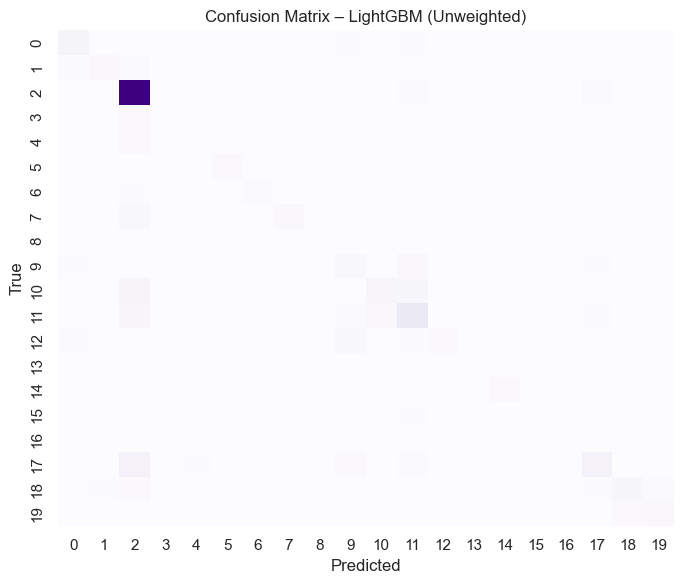


[2] LightGBM (Class-weighted)
Weighted Precision: 0.6231
Weighted Recall   : 0.5291
Weighted F1       : 0.5602


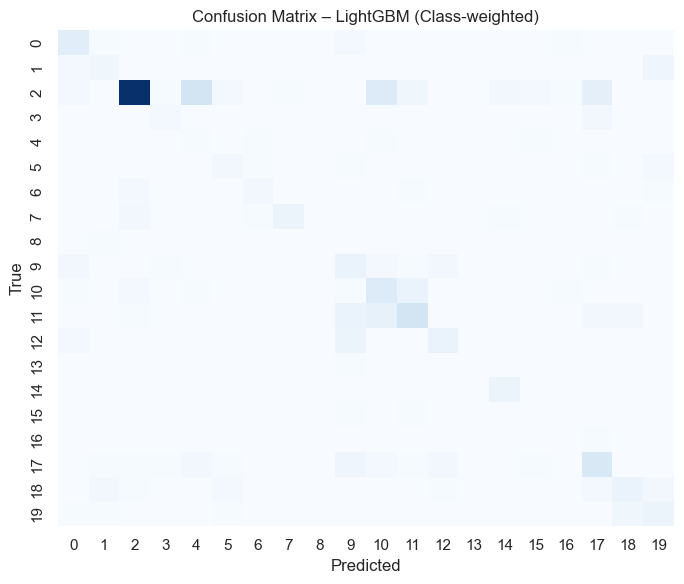


[3] Ensemble (DT + LGBM weighted)
Weighted Precision: 0.5930
Weighted Recall   : 0.4658
Weighted F1       : 0.4998


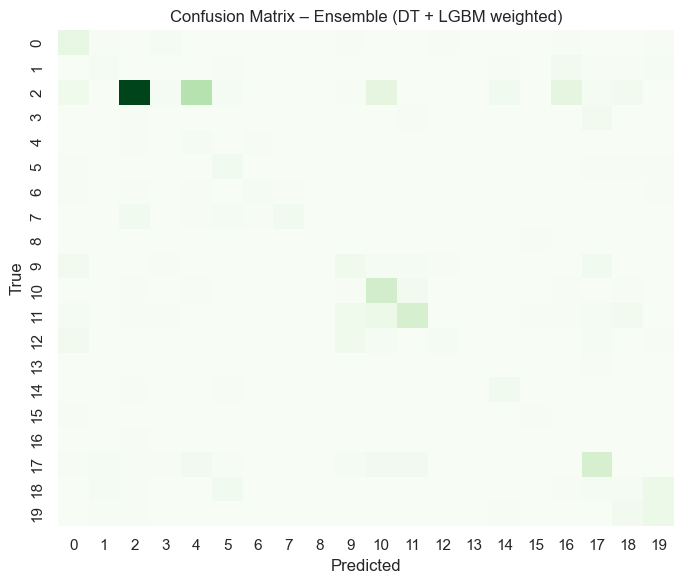

In [4]:
# ======================================================
# SAFE RELOAD OF REQUIRED VARIABLES
# (Handles kernel restarts)
# ======================================================

# y_test_labels
try:
    y_test_labels
except NameError:
    y_test_labels = y_test_multi.values.argmax(axis=1)

# LightGBM unweighted predictions
try:
    y_pred_lgb_base
except NameError:
    y_pred_lgb_base = np.argmax(model_lgb_base.predict(X_test_tree), axis=1)

# LightGBM class-weighted predictions
try:
    y_pred_lgb_w
except NameError:
    y_pred_lgb_w = np.argmax(model_lgb_w.predict(X_test_tree), axis=1)

# Ensemble predictions
try:
    y_pred_ens
except NameError:
    proba_dt = proba_dt_full
    proba_lgb = model_lgb_w.predict(X_test_tree)
    proba_ens = 0.5 * proba_dt + 0.5 * proba_lgb
    y_pred_ens = np.argmax(proba_ens, axis=1)



# ======================================================
# EXTRA METRICS — Weighted F1, Precision, Recall, CM
# ======================================================
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix
)

print("\n" + "="*70)
print("WEIGHTED METRICS FOR MULTI-CLASS MODELS")
print("="*70)


# ------------------------------------------------------
# LightGBM (unweighted)
# ------------------------------------------------------
print("\n[1] LightGBM (Unweighted)")

lgb_unw_precision_w = precision_score(y_test_labels, y_pred_lgb_base, average="weighted", zero_division=0)
lgb_unw_recall_w    = recall_score(y_test_labels, y_pred_lgb_base, average="weighted", zero_division=0)
lgb_unw_f1_w        = f1_score(y_test_labels, y_pred_lgb_base, average="weighted", zero_division=0)

print(f"Weighted Precision: {lgb_unw_precision_w:.4f}")
print(f"Weighted Recall   : {lgb_unw_recall_w:.4f}")
print(f"Weighted F1       : {lgb_unw_f1_w:.4f}")

cm_lgb_unw = confusion_matrix(y_test_labels, y_pred_lgb_base)
plt.figure(figsize=(7,6))
sns.heatmap(cm_lgb_unw, cmap="Purples", cbar=False)
plt.title("Confusion Matrix – LightGBM (Unweighted)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()



# ------------------------------------------------------
# LightGBM (Class-weighted)
# ------------------------------------------------------
print("\n[2] LightGBM (Class-weighted)")

lgb_w_precision_w = precision_score(y_test_labels, y_pred_lgb_w, average="weighted", zero_division=0)
lgb_w_recall_w    = recall_score(y_test_labels, y_pred_lgb_w, average="weighted", zero_division=0)
lgb_w_f1_w        = f1_score(y_test_labels, y_pred_lgb_w, average="weighted", zero_division=0)

print(f"Weighted Precision: {lgb_w_precision_w:.4f}")
print(f"Weighted Recall   : {lgb_w_recall_w:.4f}")
print(f"Weighted F1       : {lgb_w_f1_w:.4f}")

cm_lgb_w2 = confusion_matrix(y_test_labels, y_pred_lgb_w)
plt.figure(figsize=(7,6))
sns.heatmap(cm_lgb_w2, cmap="Blues", cbar=False)
plt.title("Confusion Matrix – LightGBM (Class-weighted)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()



# ------------------------------------------------------
# Ensemble (Decision Tree + LGBM weighted)
# ------------------------------------------------------
print("\n[3] Ensemble (DT + LGBM weighted)")

ens_precision_w = precision_score(y_test_labels, y_pred_ens, average="weighted", zero_division=0)
ens_recall_w    = recall_score(y_test_labels, y_pred_ens, average="weighted", zero_division=0)
ens_f1_w        = f1_score(y_test_labels, y_pred_ens, average="weighted", zero_division=0)

print(f"Weighted Precision: {ens_precision_w:.4f}")
print(f"Weighted Recall   : {ens_recall_w:.4f}")
print(f"Weighted F1       : {ens_f1_w:.4f}")

cm_ens = confusion_matrix(y_test_labels, y_pred_ens)
plt.figure(figsize=(7,6))
sns.heatmap(cm_ens, cmap="Greens", cbar=False)
plt.title("Confusion Matrix – Ensemble (DT + LGBM weighted)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()


Preparing data for Random Forest and Results

In [ ]:
from sklearn.utils import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix


def prepare_for_random_forest(df):
    # 2. Remove very rare classes (recommended for better performance)
    diagnosis_counts = df['diagnosis'].value_counts()
    min_samples = 5  # Classes with fewer than 5 samples will be removed
    valid_classes = diagnosis_counts[diagnosis_counts >= min_samples].index
    df_processed = df[df['diagnosis'].isin(valid_classes)]

    print(f"\nAfter filtering rare classes: {len(df_processed)} samples, {len(valid_classes)} classes")
    print(df_processed['diagnosis'].value_counts())

    # Target remains as original strings
    y = df_processed['diagnosis']

    # Feature encoding (your existing logic)
    X_df = df_processed.drop(columns=['clinic', 'derm', 'case_num', 'case_id', 'notes', 'diagnosis'])

    for column in X_df.columns:
        if column in ['blue_whitish_veil']:
            X_df[column] = X_df[column].map({'present': 1, 'absent': 0})
        elif column in ['sex']:
            X_df[column] = X_df[column].map({'male': 1, 'female': 0})
        elif column in ['level_of_diagnostic_difficulty']:
            difficulty_map = {'low': 0, 'medium': 1, 'high': 2}
            X_df[column] = X_df[column].map(difficulty_map)
        elif X_df[column].dtype == 'object':
            X_df = pd.get_dummies(X_df, columns=[column], prefix=column)

    return X_df, y, valid_classes


def train_random_forest(X, y):
    # Calculate class weights for imbalance
    classes = np.unique(y)
    class_weights = compute_class_weight(
        'balanced',
        classes=classes,
        y=y
    )
    class_weight_dict = dict(zip(classes, class_weights))

    print("\nClass Weights:")
    for cls, weight in class_weight_dict.items():
        print(f"  {cls}: {weight:.2f}")

    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Initialize Random Forest with optimal parameters for medical data
    rf_model = RandomForestClassifier(
        n_estimators=150,  # More trees for stability
        max_depth=20,  # Prevent overfitting
        min_samples_split=5,  # Require minimum samples to split
        min_samples_leaf=3,  # Require minimum samples in leaf
        class_weight=class_weight_dict,  # Handle class imbalance
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    )

    # Cross-validation
    print("\nPerforming Cross-Validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_model, X_train, y_train,
                                cv=cv, scoring='f1_macro', n_jobs=-1)

    print(f"Cross-Validation F1 Macro: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Train final model
    print("\nTraining Final Model...")
    rf_model.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = rf_model.predict(X_test)

    return rf_model, X_test, y_test, y_pred, X_train, y_train


def evaluate_model(rf_model, X_test, y_test, y_pred):
    print("\n" + "=" * 50)
    print("MODEL EVALUATION")
    print("=" * 50)

    # Key metrics
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Macro F1 Score: {f1_macro:.4f}")
    print(f"Weighted F1 Score: {f1_weighted:.4f}")

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    return feature_importance, f1_macro


def plot_feature_importance(feature_importance, top_n=15):
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(top_n)

    sns.barplot(data=top_features, y='feature', x='importance')
    plt.title(f'Top {top_n} Most Important Features - Random Forest')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(rf_model, X_test, y_test):
    y_pred = rf_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=rf_model.classes_,
                yticklabels=rf_model.classes_)
    plt.title('Confusion Matrix - Random Forest')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


fresh_df = pd.read_csv("../Dataset/DERM7PT/meta/meta.csv")
X_df, y, valid_classes = prepare_for_random_forest(fresh_df)
# print(y)
rf_model, X_test, y_test, y_pred, X_train, y_train = train_random_forest(X_df, y)
feature_importance, f1_macro = evaluate_model(rf_model, X_test, y_test, y_pred)

plot_feature_importance(feature_importance)
plot_confusion_matrix(rf_model, X_test, y_test)

# Final model summary
print("\n" + "=" * 50)
print("MODEL SUMMARY FOR RANDOM FOREST")
print("=" * 50)
print(f"Classes: {len(valid_classes)}")
print(f"Features: {X_df.shape[1]}")
print(f"Samples: {X_df.shape[0]}")
print(f"Final Test Macro F1: {f1_macro:.4f}")

# X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify=y)
# bernoulli = BernoulliNB(alpha=1.0,binarize=None)
# bernoulli.fit(X_train_new, y_train_new)
# y_prediction_new = bernoulli.predict(X_test_new)
# print(classification_report(y_test_new, y_prediction_new, zero_division=0))


Preparing data for Naive Bayes (Bernoulli and Gaussian) and Results

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import Binarizer


def prepare_for_naive_bayes(df):
    # 2. Remove very rare classes (recommended for better performance)
    diagnosis_counts = df['diagnosis'].value_counts()
    min_samples = 5  # Classes with fewer than 5 samples will be removed
    valid_classes = diagnosis_counts[diagnosis_counts >= min_samples].index
    df_processed = df[df['diagnosis'].isin(valid_classes)]

    print(f"\nAfter filtering rare classes: {len(df_processed)} samples, {len(valid_classes)} classes")
    print(df_processed['diagnosis'].value_counts())

    # Target remains as original strings
    y = df_processed['diagnosis']

    # Feature encoding (your existing logic)
    X_df = df_processed.drop(columns=['clinic', 'derm', 'case_num', 'case_id', 'notes', 'diagnosis'])

    for column in X_df.columns:
        if column in ['blue_whitish_veil']:
            X_df[column] = X_df[column].map({'present': 1, 'absent': 0})
        elif column in ['sex']:
            X_df[column] = X_df[column].map({'male': 1, 'female': 0})
        elif column in ['level_of_diagnostic_difficulty']:
            difficulty_map = {'low': 0, 'medium': 1, 'high': 2}
            X_df[column] = X_df[column].map(difficulty_map)
        elif X_df[column].dtype == 'object':
            X_df = pd.get_dummies(X_df, columns=[column], prefix=column)

    return X_df, y, valid_classes


def plot_nb_feature_importance_cv(model, X, y, top_n=15):
    # Fit on full data to extract feature_log_prob_
    model.fit(X, y)

    # Log P(feature=1 | class)
    feature_importance_df = pd.DataFrame(
        model.feature_log_prob_.T,
        index=X.columns,
        columns=[f"class_{c}" for c in model.classes_]
    )

    # Average importance across all classes
    feature_importance_df['avg_importance'] = feature_importance_df.mean(axis=1)

    # Select top N
    top_features = (
        feature_importance_df['avg_importance']
        .sort_values(ascending=False)
        .head(top_n)
    )

    plt.figure(figsize=(10, 8))
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        orient='h'
    )
    plt.title(f"Top {top_n} Most Important Features (BernoulliNB)")
    plt.xlabel("Average Log Probability")
    plt.tight_layout()
    plt.show()

    return feature_importance_df


def plot_cv_confusion_matrix(y_true, y_pred):
    classes_new = np.unique(y)
    cm = confusion_matrix(y_true, y_pred, labels=classes_new)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=classes_new,
        yticklabels=classes_new
    )
    plt.title("Confusion Matrix - BernoulliNB (Cross-Validated)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


fresh_df = pd.read_csv("../Dataset/DERM7PT/meta/meta.csv")
X_df, y, valid_classes = prepare_for_naive_bayes(fresh_df)
# print(y)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify=y)
# bernoulli = BernoulliNB(alpha=1.0,binarize=None)
# bernoulli.fit(X_train_new, y_train_new)
# y_prediction_new = bernoulli.predict(X_test_new)
# print(classification_report(y_test_new, y_prediction_new, zero_division=0))

binarizer = Binarizer(threshold=0.0)
X_bin = binarizer.fit_transform(X_df)

# --- STRATIFIED K-FOLD ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = BernoulliNB(alpha=1.0, binarize=None)
model_gaussian = GaussianNB()

# --- CV ACCURACY SCORES ---
cv_scores = cross_val_score(model, X_bin, y, cv=skf, scoring='accuracy')
cv_scores_gaussian = cross_val_score(model_gaussian, X_bin, y, cv=skf, scoring='accuracy')

print("\nAccuracy per fold:", cv_scores)
print("Mean accuracy:", cv_scores.mean())
print("Std deviation:", cv_scores.std())

print("\nAccuracy per fold:", cv_scores_gaussian)
print("Mean accuracy:", cv_scores_gaussian.mean())
print("Std deviation:", cv_scores_gaussian.std())

# --- CV PREDICTIONS FOR FULL REPORT ---
y_pred_cv = cross_val_predict(model, X_bin, y, cv=skf)
y_pred_gaussian = cross_val_predict(model_gaussian, X_bin, y, cv=skf)

print("\nClassification Report For BernoulliNB:")
print(classification_report(y, y_pred_cv, zero_division=0))

print("\nClassification Report For GaussianNB:")
print(classification_report(y, y_pred_gaussian, zero_division=0))

print("\nConfusion Matrix For BernoulliNB:")
print(confusion_matrix(y, y_pred_cv))

print("\nConfusion Matrix For GaussianNB:")
print(confusion_matrix(y, y_pred_gaussian))

plot_cv_confusion_matrix(y, y_pred_cv)
feature_df = plot_nb_feature_importance_cv(model, X_df, y)

# plot_cv_confusion_matrix(y, y_pred_gaussian)
# feature_df_gaussian = plot_nb_feature_importance_cv(model_gaussian, X_df, y)


# nb_model = BernoulliNB()
# model.fit(X_train_new, y_train_new)
# y_pred = model.predict(X_test_new)
#
# feat_df, f1_macro = evaluate_nb_model(model, X_test_new, y_test_new, y_pred)
# plot_nb_feature_importance(feat_df)
# plot_nb_confusion_matrix(model, X_test_new, y_test_new)


Testing SMOTE Optimization with Random Forest, Logistic Regression and SVM and Results

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, GaussianNB


def preprocess_data(df):
    # Filter rare classes - increased minimum samples to avoid SMOTE issues
    diagnosis_counts = df['diagnosis'].value_counts()
    min_samples = 10  # Increased from 5 to 10 for better SMOTE performance
    valid_classes = diagnosis_counts[diagnosis_counts >= min_samples].index
    df_processed = df[df['diagnosis'].isin(valid_classes)]

    print(f"After filtering rare classes: {len(df_processed)} samples, {len(valid_classes)} classes")
    print(df_processed['diagnosis'].value_counts())

    # Target
    y = df_processed['diagnosis']

    # Features
    X_df = df_processed.drop(columns=['clinic', 'derm', 'case_num', 'case_id', 'notes', 'diagnosis'])

    # Encoding
    for column in X_df.columns:
        if column in ['blue_whitish_veil']:
            X_df[column] = X_df[column].map({'present': 1, 'absent': 0})
        elif column in ['sex']:
            X_df[column] = X_df[column].map({'male': 1, 'female': 0})
        elif column in ['level_of_diagnostic_difficulty']:
            difficulty_map = {'low': 0, 'medium': 1, 'high': 2}
            X_df[column] = X_df[column].map(difficulty_map)
        elif X_df[column].dtype == 'object':
            X_df = pd.get_dummies(X_df, columns=[column], prefix=column)

    # Handle any NaN values that might have been introduced
    X_df = X_df.fillna(0)

    return X_df, y, valid_classes


def evaluate_models(X, y, X_smote, y_smote, test_size=0.2, random_state=42):
    # Encode labels for sklearn
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_smote_encoded = le.transform(y_smote)  # Use same encoder

    # Split original data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )

    # Split SMOTE data (use same test indices for fair comparison)
    X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
        X_smote, y_smote_encoded, test_size=test_size, random_state=random_state, stratify=y_smote_encoded
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    scaler_smote = StandardScaler()
    X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)
    X_test_smote_scaled = scaler_smote.transform(X_test_smote)

    # Define models to test
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
        'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000),
        'SVM': SVC(random_state=random_state)
    }

    results = {}

    for model_name, model in models.items():
        print(f"\n{'=' * 50}")
        print(f"Evaluating {model_name}")
        print(f"{'=' * 50}")

        # On Original Data
        print("\n--- On Original Data ---")
        model_original = model
        model_original.fit(X_train_scaled, y_train)
        y_pred_original = model_original.predict(X_test_scaled)

        accuracy_original = accuracy_score(y_test, y_pred_original)
        f1_original = f1_score(y_test, y_pred_original, average='weighted', zero_division=0)

        print(f"Accuracy: {accuracy_original:.4f}")
        print(f"F1-Score: {f1_original:.4f}")

        # On SMOTE Data
        print("\n--- On SMOTE Data ---")
        model_smote = model
        model_smote.fit(X_train_smote_scaled, y_train_smote)
        y_pred_smote = model_smote.predict(X_test_scaled)  # Test on original test data

        accuracy_smote = accuracy_score(y_test, y_pred_smote)
        f1_smote = f1_score(y_test, y_pred_smote, average='weighted', zero_division=0)

        print(f"Accuracy: {accuracy_smote:.4f}")
        print(f"F1-Score: {f1_smote:.4f}")

        # Store results
        results[model_name] = {
            'Original_Data': {'accuracy': accuracy_original, 'f1': f1_original},
            'SMOTE_Data': {'accuracy': accuracy_smote, 'f1': f1_smote}
        }

        # Detailed classification report for the best model
        if f1_smote > f1_original:
            best_predictions = y_pred_smote
            best_model_type = "SMOTE Data"
        else:
            best_predictions = y_pred_original
            best_model_type = "Original Data"

        print(f"\nBest model: {best_model_type}")
        print("\nClassification Report:")
        print(classification_report(y_test, best_predictions, target_names=le.classes_, zero_division=0))

    return results, le.classes_


def cross_validation_comparison(X, y, X_smote, y_smote, n_splits=5):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_smote_encoded = le.transform(y_smote)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    scaler_smote = StandardScaler()
    X_smote_scaled = scaler_smote.fit_transform(X_smote)

    # Custom scoring function that handles zero_division
    from sklearn.metrics import make_scorer
    f1_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

    # Models to evaluate
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(random_state=42)
    }

    cv_results = {}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for model_name, model in models.items():
        print(f"\n{model_name} Cross-Validation Results:")

        # On Original Data
        scores_original = cross_val_score(model, X_scaled, y_encoded, cv=skf, scoring=f1_scorer)

        # On SMOTE Data
        scores_smote = cross_val_score(model, X_smote_scaled, y_smote_encoded, cv=skf, scoring=f1_scorer)

        cv_results[model_name] = {
            'Original_Data': {
                'mean_f1': np.mean(scores_original),
                'std_f1': np.std(scores_original)
            },
            'SMOTE_Data': {
                'mean_f1': np.mean(scores_smote),
                'std_f1': np.std(scores_smote)
            }
        }

        print(f"  Original Data: {np.mean(scores_original):.4f} ± {np.std(scores_original):.4f}")
        print(f"  SMOTE Data:    {np.mean(scores_smote):.4f} ± {np.std(scores_smote):.4f}")

    return cv_results


def plot_comparison(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    models = list(results.keys())
    original_acc = [results[model]['Original_Data']['accuracy'] for model in models]
    smote_acc = [results[model]['SMOTE_Data']['accuracy'] for model in models]
    original_f1 = [results[model]['Original_Data']['f1'] for model in models]
    smote_f1 = [results[model]['SMOTE_Data']['f1'] for model in models]

    x = np.arange(len(models))
    width = 0.35

    # Accuracy plot
    bars1 = ax1.bar(x - width / 2, original_acc, width, label='Original Data', alpha=0.7, color='skyblue')
    bars2 = ax1.bar(x + width / 2, smote_acc, width, label='SMOTE Data', alpha=0.7, color='lightcoral')
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy: Original vs SMOTE Data')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()

    # Add value labels on bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.3f}', ha='center', va='bottom')

    # F1-Score plot
    bars3 = ax2.bar(x - width / 2, original_f1, width, label='Original Data', alpha=0.7, color='skyblue')
    bars4 = ax2.bar(x + width / 2, smote_f1, width, label='SMOTE Data', alpha=0.7, color='lightcoral')
    ax2.set_xlabel('Models')
    ax2.set_ylabel('F1-Score')
    ax2.set_title('Model F1-Score: Original vs SMOTE Data')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()

    # Add value labels on bars
    for bar in bars3 + bars4:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def analyze_class_distribution(y):
    class_counts = pd.Series(y).value_counts()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
    plt.title('Class Distribution (%)')

    plt.tight_layout()
    plt.show()

    print("Class distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} samples")

    return class_counts


if __name__ == "__main__":
    # Loading data
    df = pd.read_csv('../Dataset/DERM7PT/meta/meta.csv')

    print("Original dataset shape:", df.shape)
    print("\nOriginal class distribution:")
    print(df['diagnosis'].value_counts())

    # Analyze original class distribution
    analyze_class_distribution(df['diagnosis'])

    # Preprocess data
    X, y, classes = preprocess_data(df)

    print(f"\nProcessed features shape: {X.shape}")
    print(f"Number of features: {X.shape[1]}")

    # Analyze processed class distribution
    analyze_class_distribution(y)

    # Apply SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    x_new, y_new = smote.fit_resample(X, y)

    print("\nAfter SMOTE resampling:")
    print(y_new.value_counts())

    print("\nDiagnosis after SMOTE resampling:")
    x_new.to_csv("sampling.csv", index=False)

    # Analyze SMOTE class distribution
    analyze_class_distribution(y_new)

    # Single train-test split evaluation
    print("\n" + "=" * 60)
    print("SINGLE TRAIN-TEST SPLIT EVALUATION")
    print("=" * 60)
    results, class_names = evaluate_models(X, y, x_new, y_new)

    # Cross-validation evaluation (more robust)
    print("\n" + "=" * 60)
    print("CROSS-VALIDATION EVALUATION")
    print("=" * 60)
    cv_results = cross_validation_comparison(X, y, x_new, y_new)

    # Plot results
    plot_comparison(results)

    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)

    for model_name in results.keys():
        original_acc = results[model_name]['Original_Data']['accuracy']
        smote_acc = results[model_name]['SMOTE_Data']['accuracy']
        original_f1 = results[model_name]['Original_Data']['f1']
        smote_f1 = results[model_name]['SMOTE_Data']['f1']

        acc_improvement = smote_acc - original_acc
        f1_improvement = smote_f1 - original_f1

        print(f"\n{model_name}:")
        print(f"  Original Data - Accuracy: {original_acc:.4f}, F1: {original_f1:.4f}")
        print(f"  SMOTE Data    - Accuracy: {smote_acc:.4f}, F1: {smote_f1:.4f}")
        print(f"  Accuracy improvement: {acc_improvement:+.4f}")
        print(f"  F1-Score improvement: {f1_improvement:+.4f}")
        print(f"  SMOTE beneficial: {'YES' if f1_improvement > 0 else 'NO'}")

    # Cross-validation summary
    print("\n" + "=" * 60)
    print("CROSS-VALIDATION SUMMARY")
    print("=" * 60)
    for model_name in cv_results.keys():
        original_mean = cv_results[model_name]['Original_Data']['mean_f1']
        smote_mean = cv_results[model_name]['SMOTE_Data']['mean_f1']
        improvement = smote_mean - original_mean

        print(f"\n{model_name}:")
        print(f"  CV F1 Original Data: {original_mean:.4f} ± {cv_results[model_name]['Original_Data']['std_f1']:.4f}")
        print(f"  CV F1 SMOTE Data:    {smote_mean:.4f} ± {cv_results[model_name]['SMOTE_Data']['std_f1']:.4f}")
        print(f"  CV F1 Improvement: {improvement:+.4f}")

Modified SMOTE code to use for KNN Classifier and Results

KNN MODEL ANALYSIS - WITHOUT SMOTE
Original dataset shape: (1011, 19)

Original class distribution:
diagnosis
clark nevus                     399
melanoma (less than 0.76 mm)    102
reed or spitz nevus              79
melanoma (in situ)               64
melanoma (0.76 to 1.5 mm)        53
seborrheic keratosis             45
basal cell carcinoma             42
dermal nevus                     33
vascular lesion                  29
blue nevus                       28
melanoma (more than 1.5 mm)      28
lentigo                          24
dermatofibroma                   20
congenital nevus                 17
melanosis                        16
combined nevus                   13
miscellaneous                     8
recurrent nevus                   6
melanoma metastasis               4
melanoma                          1
Name: count, dtype: int64


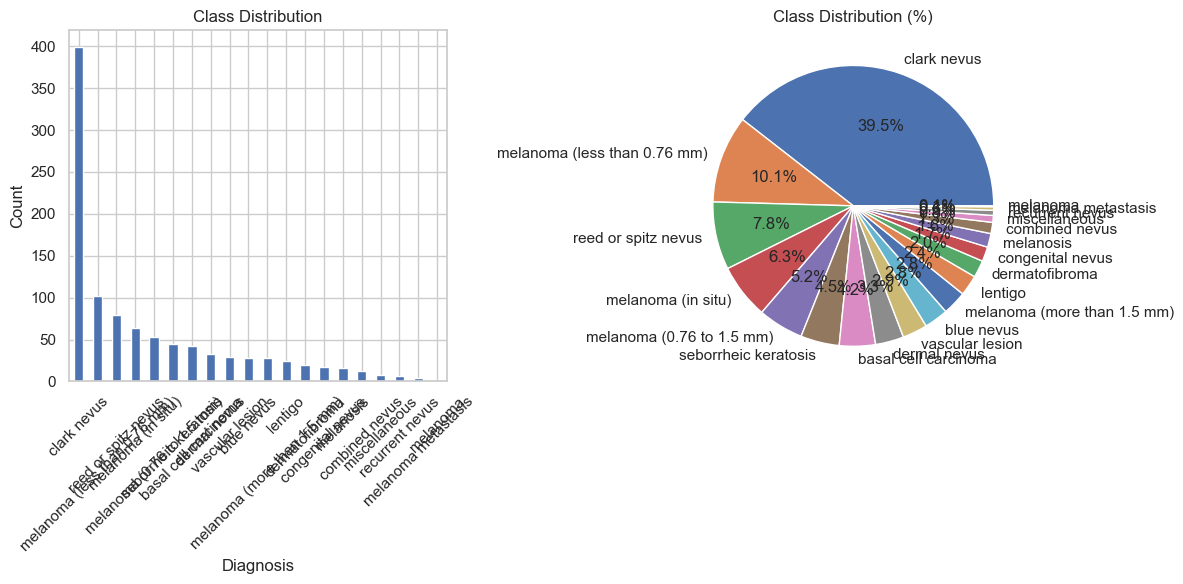

Class distribution:
  clark nevus: 399 samples
  melanoma (less than 0.76 mm): 102 samples
  reed or spitz nevus: 79 samples
  melanoma (in situ): 64 samples
  melanoma (0.76 to 1.5 mm): 53 samples
  seborrheic keratosis: 45 samples
  basal cell carcinoma: 42 samples
  dermal nevus: 33 samples
  vascular lesion: 29 samples
  blue nevus: 28 samples
  melanoma (more than 1.5 mm): 28 samples
  lentigo: 24 samples
  dermatofibroma: 20 samples
  congenital nevus: 17 samples
  melanosis: 16 samples
  combined nevus: 13 samples
  miscellaneous: 8 samples
  recurrent nevus: 6 samples
  melanoma metastasis: 4 samples
  melanoma: 1 samples
After filtering rare classes: 992 samples, 16 classes
diagnosis
clark nevus                     399
melanoma (less than 0.76 mm)    102
reed or spitz nevus              79
melanoma (in situ)               64
melanoma (0.76 to 1.5 mm)        53
seborrheic keratosis             45
basal cell carcinoma             42
dermal nevus                     33
vascular l

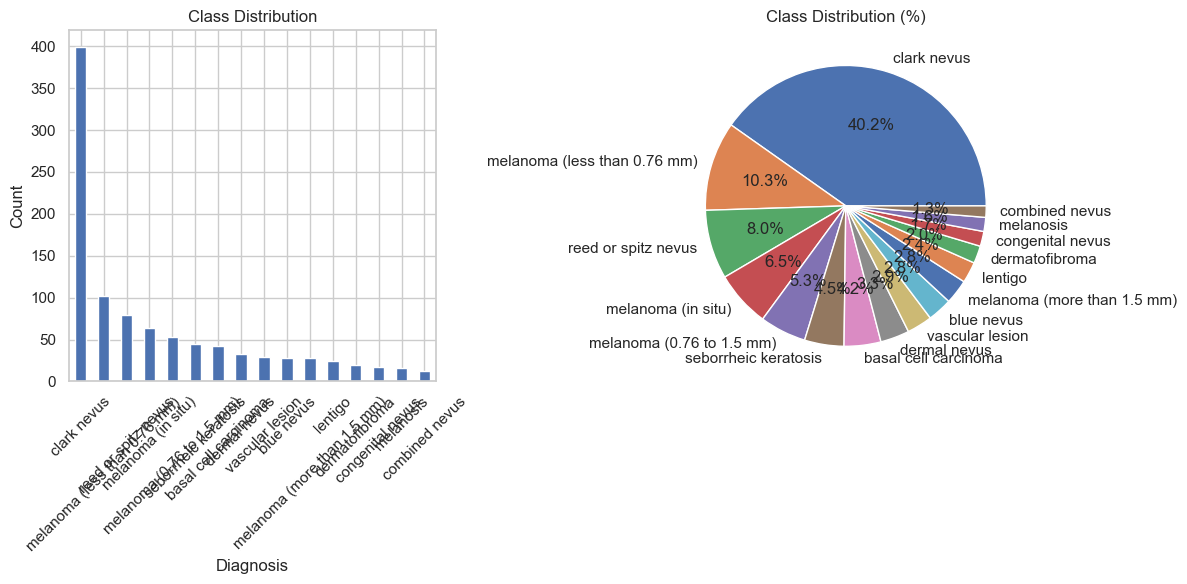

Class distribution:
  clark nevus: 399 samples
  melanoma (less than 0.76 mm): 102 samples
  reed or spitz nevus: 79 samples
  melanoma (in situ): 64 samples
  melanoma (0.76 to 1.5 mm): 53 samples
  seborrheic keratosis: 45 samples
  basal cell carcinoma: 42 samples
  dermal nevus: 33 samples
  vascular lesion: 29 samples
  blue nevus: 28 samples
  melanoma (more than 1.5 mm): 28 samples
  lentigo: 24 samples
  dermatofibroma: 20 samples
  congenital nevus: 17 samples
  melanosis: 16 samples
  combined nevus: 13 samples

KNN PERFORMANCE ACROSS DIFFERENT K VALUES


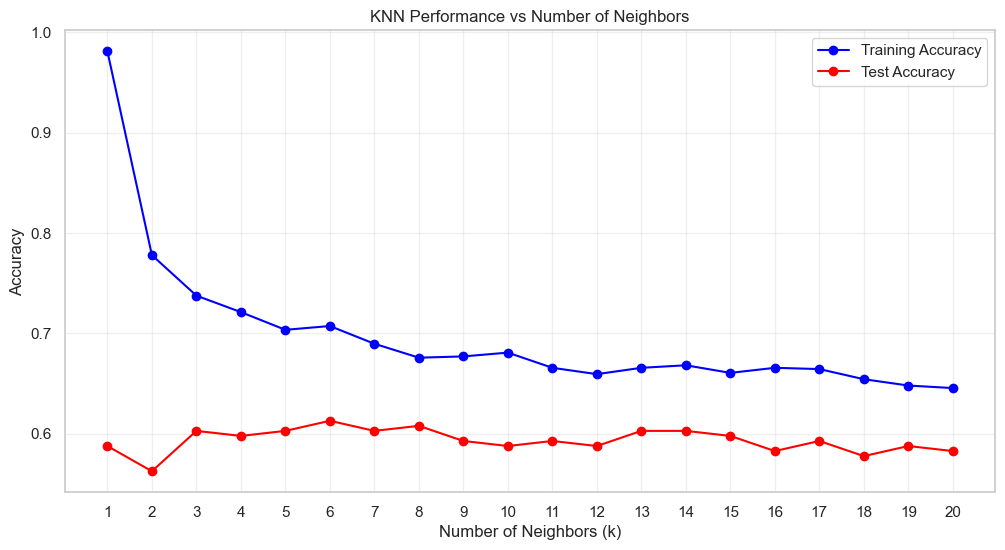

Optimal k value: 6 with test accuracy: 0.6131

KNN MODEL EVALUATION WITH HYPERPARAMETER TUNING
K-NEAREST NEIGHBORS (KNN) MODEL EVALUATION

--- Hyperparameter Tuning ---
Best parameters: {'n_neighbors': 8}
Best cross-validation score: 0.5610

--- Test Set Performance ---
Accuracy: 0.6080
Precision: 0.5918
Recall: 0.6080
F1-Score: 0.5763

--- Detailed Classification Report ---
                              precision    recall  f1-score   support

        basal cell carcinoma       0.57      0.50      0.53         8
                  blue nevus       0.14      0.17      0.15         6
                 clark nevus       0.72      0.96      0.82        80
              combined nevus       1.00      0.50      0.67         2
            congenital nevus       0.00      0.00      0.00         3
                dermal nevus       0.60      0.43      0.50         7
              dermatofibroma       1.00      0.50      0.67         4
                     lentigo       0.80      0.80      0.80  

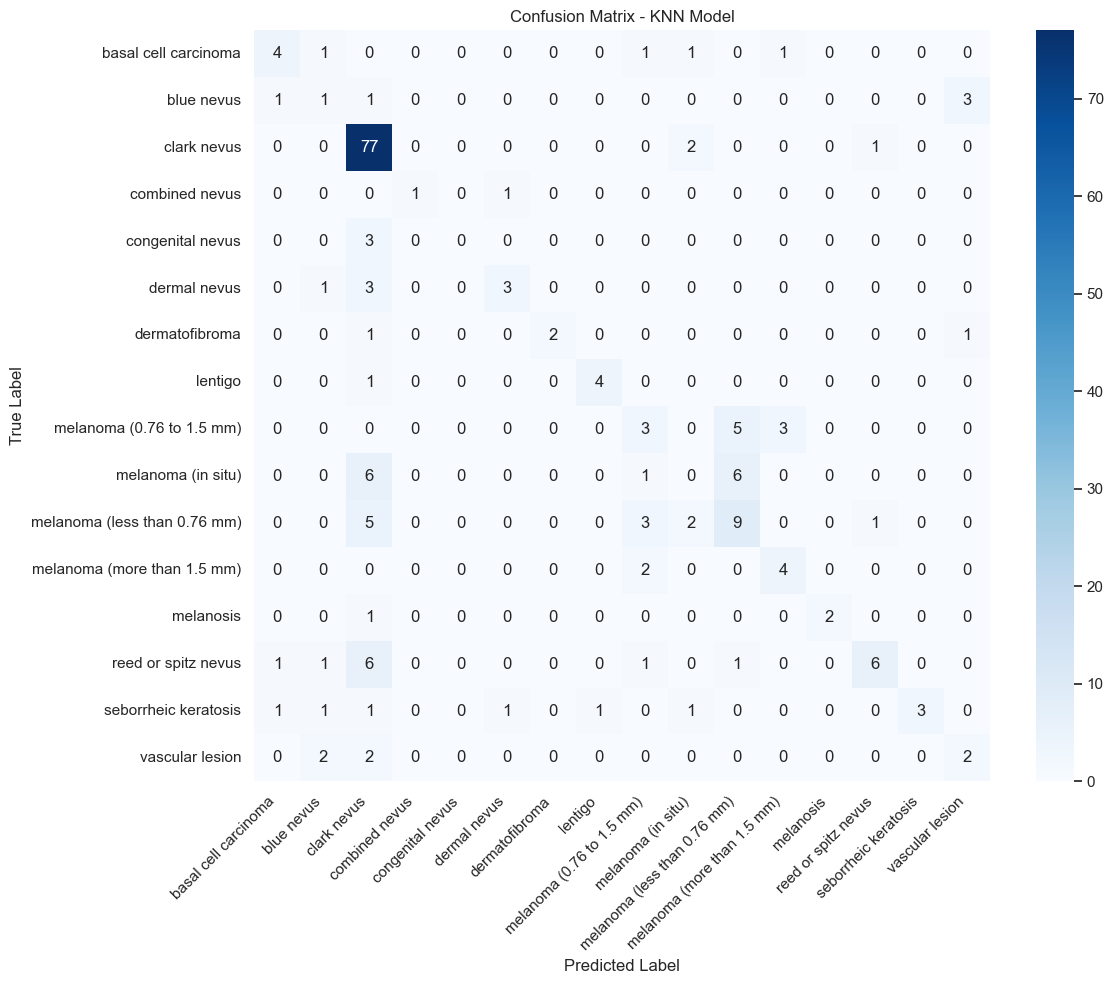


FEATURE IMPORTANCE ANALYSIS


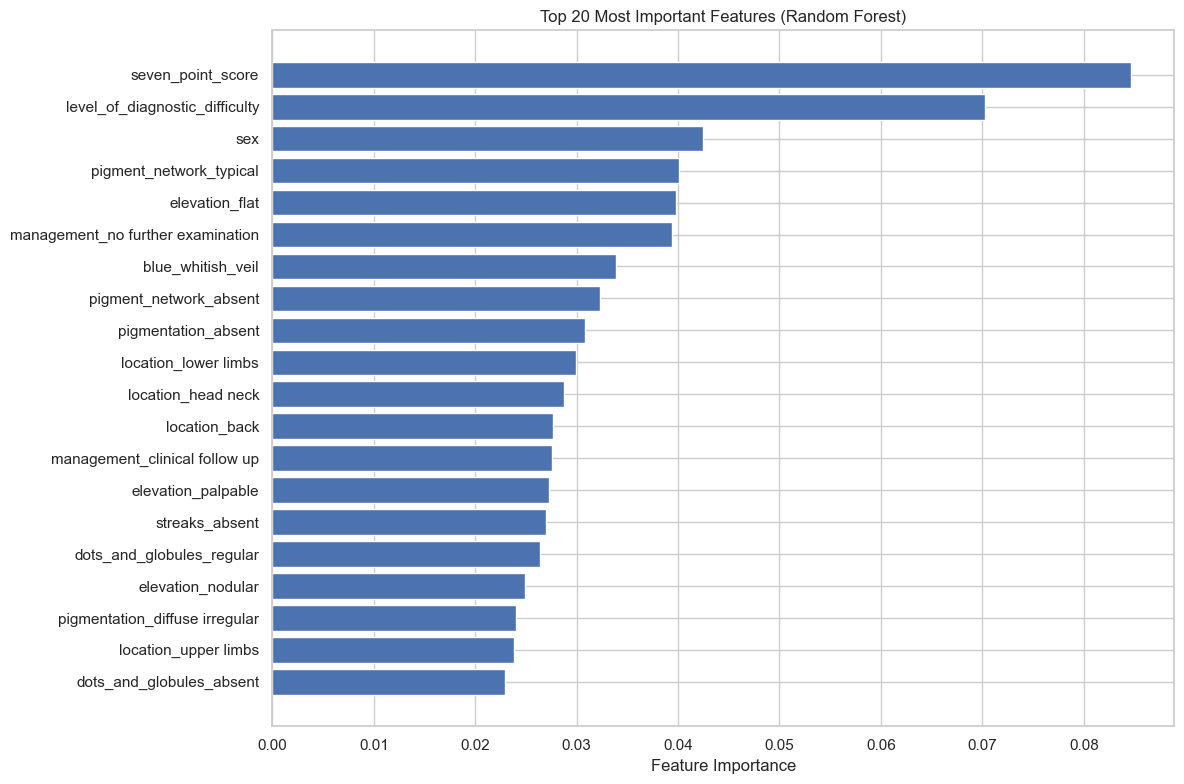


FINAL SUMMARY - KNN MODEL
Best Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}

Performance Metrics:
  Accuracy:  0.6080
  Precision: 0.5918
  Recall:    0.6080
  F1-Score:  0.5763

Class-wise Performance:
  basal cell carcinoma: 0.500 (4/8)
  blue nevus: 0.167 (1/6)
  clark nevus: 0.963 (77/80)
  combined nevus: 0.500 (1/2)
  congenital nevus: 0.000 (0/3)
  dermal nevus: 0.429 (3/7)
  dermatofibroma: 0.500 (2/4)
  lentigo: 0.800 (4/5)
  melanoma (0.76 to 1.5 mm): 0.273 (3/11)
  melanoma (in situ): 0.000 (0/13)
  melanoma (less than 0.76 mm): 0.450 (9/20)
  melanoma (more than 1.5 mm): 0.667 (4/6)
  melanosis: 0.667 (2/3)
  reed or spitz nevus: 0.375 (6/16)
  seborrheic keratosis: 0.333 (3/9)
  vascular lesion: 0.333 (2/6)

Dataset Characteristics:
  Total samples: 992
  Number of features: 71
  Number of classes: 16
  Class imbalance ratio: 30.69:1


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, \
    recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


def preprocess_data(df):
    # Filter rare classes
    diagnosis_counts = df['diagnosis'].value_counts()
    min_samples = 10
    valid_classes = diagnosis_counts[diagnosis_counts >= min_samples].index
    df_processed = df[df['diagnosis'].isin(valid_classes)]

    print(f"After filtering rare classes: {len(df_processed)} samples, {len(valid_classes)} classes")
    print(df_processed['diagnosis'].value_counts())

    # Target
    y = df_processed['diagnosis']

    # Features
    X_df = df_processed.drop(columns=['clinic', 'derm', 'case_num', 'notes', 'diagnosis'])

    # Encoding
    for column in X_df.columns:
        if column in ['blue_whitish_veil']:
            X_df[column] = X_df[column].map({'present': 1, 'absent': 0})
        elif column in ['sex']:
            X_df[column] = X_df[column].map({'male': 1, 'female': 0})
        elif column in ['level_of_diagnostic_difficulty']:
            difficulty_map = {'low': 0, 'medium': 1, 'high': 2}
            X_df[column] = X_df[column].map(difficulty_map)
        elif X_df[column].dtype == 'object':
            X_df = pd.get_dummies(X_df, columns=[column], prefix=column)

    # Handle any NaN values that might have been introduced
    X_df = X_df.fillna(0)

    return X_df, y, valid_classes


def evaluate_knn(X, y, test_size=0.2, random_state=42):
    # Encode labels for sklearn
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )

    # Scale features (important for KNN)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("=" * 60)
    print("K-NEAREST NEIGHBORS (KNN) MODEL EVALUATION")
    print("=" * 60)

    # Hyperparameter tuning for K
    print("\n--- Hyperparameter Tuning ---")
    param_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9]}
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Train with best parameters
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\n--- Test Set Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Detailed classification report
    print(f"\n--- Detailed Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

    # Cross-validation with best model
    print(f"\n--- Cross-Validation Results (5-fold) ---")
    cv_scores = cross_val_score(best_knn, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
    print(f"CV F1-Scores: {cv_scores}")
    print(f"Mean CV F1-Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return best_knn, y_test, y_pred, le.classes_, accuracy, f1, precision, recall


def plot_confusion_matrix(y_test, y_pred, class_names):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix - KNN Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def plot_knn_performance(X, y):
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Test different k values
    k_values = range(1, 21)
    train_scores = []
    test_scores = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)

        train_score = knn.score(X_train_scaled, y_train)
        test_score = knn.score(X_test_scaled, y_test)

        train_scores.append(train_score)
        test_scores.append(test_score)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, train_scores, 'o-', label='Training Accuracy', color='blue')
    plt.plot(k_values, test_scores, 'o-', label='Test Accuracy', color='red')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('KNN Performance vs Number of Neighbors')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    plt.show()

    # Find optimal k
    optimal_k = k_values[np.argmax(test_scores)]
    print(f"Optimal k value: {optimal_k} with test accuracy: {max(test_scores):.4f}")


def analyze_class_distribution(y):
    class_counts = pd.Series(y).value_counts()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
    plt.title('Class Distribution (%)')

    plt.tight_layout()
    plt.show()

    print("Class distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} samples")

    return class_counts


def feature_importance_analysis(X, y):
    from sklearn.ensemble import RandomForestClassifier

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Use Random Forest to get feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y_encoded)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important Features (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return feature_importance


if __name__ == "__main__":
    # Loading data
    df = pd.read_csv('../Dataset/DERM7PT/meta/meta.csv')

    print("KNN MODEL ANALYSIS - WITHOUT SMOTE")
    print("=" * 50)
    print(f"Original dataset shape: {df.shape}")
    print("\nOriginal class distribution:")
    print(df['diagnosis'].value_counts())

    # Analyze original class distribution
    analyze_class_distribution(df['diagnosis'])

    # Preprocess data
    X, y, classes = preprocess_data(df)

    print(f"\nProcessed features shape: {X.shape}")
    print(f"Number of features: {X.shape[1]}")

    # Analyze processed class distribution
    analyze_class_distribution(y)

    # KNN performance across different k values
    print("\n" + "=" * 60)
    print("KNN PERFORMANCE ACROSS DIFFERENT K VALUES")
    print("=" * 60)
    plot_knn_performance(X, y)

    # Evaluate KNN with hyperparameter tuning
    print("\n" + "=" * 60)
    print("KNN MODEL EVALUATION WITH HYPERPARAMETER TUNING")
    print("=" * 60)
    best_knn, y_test, y_pred, class_names, accuracy, f1, precision, recall = evaluate_knn(X, y)

    # Plot confusion matrix
    print("\n" + "=" * 60)
    print("CONFUSION MATRIX ANALYSIS")
    print("=" * 60)
    plot_confusion_matrix(y_test, y_pred, class_names)

    # Feature importance analysis
    print("\n" + "=" * 60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    feature_importance = feature_importance_analysis(X, y)

    # Final summary
    print("\n" + "=" * 60)
    print("FINAL SUMMARY - KNN MODEL")
    print("=" * 60)
    print(f"Best Model Parameters: {best_knn.get_params()}")
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    # Class-wise performance from confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nClass-wise Performance:")
    for i, class_name in enumerate(class_names):
        true_positives = cm[i, i]
        total_actual = cm[i, :].sum()
        if total_actual > 0:
            class_accuracy = true_positives / total_actual
            print(f"  {class_name}: {class_accuracy:.3f} ({true_positives}/{total_actual})")

    print(f"\nDataset Characteristics:")
    print(f"  Total samples: {len(X)}")
    print(f"  Number of features: {X.shape[1]}")
    print(f"  Number of classes: {len(class_names)}")
    print(f"  Class imbalance ratio: {pd.Series(y).value_counts().max() / pd.Series(y).value_counts().min():.2f}:1")